# Install libraries

In [ ]:
!pip install --upgrade open_spiel

# Import libraries

In [ ]:
"""Policy gradient agents trained and evaluated on Kuhn Poker."""

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

from absl import app
from absl import flags
from absl import logging

import pandas as pd
import numpy as np
from statistics import mean, stdev

from matplotlib import pyplot as plt

import tensorflow.compat.v1 as tf

# from open_spiel.python import policy
from open_spiel.python import rl_environment
from open_spiel.python.algorithms import policy_gradient
from open_spiel.python.algorithms import dqn
from open_spiel.python.bots import human
from open_spiel.python.bots import uniform_random
import pyspiel

SEED = 42

Instructions for updating:
non-resource variables are not supported in the long term


# Utility functions to evaluate trained agents against different baseline bots

## Load bot agents

In [ ]:
def load_agent(agent_type, game, player_id, rng):
  """Return a bot based on the agent type."""
  if agent_type == "random":
    return uniform_random.UniformRandomBot(player_id, rng)
  elif agent_type == "human":
    return human.HumanBot()
  elif agent_type == "check_call":
    policy = pyspiel.PreferredActionPolicy([1, 0])
    return pyspiel.make_policy_bot(game, player_id, SEED, policy)
  elif agent_type == "fold":
    policy = pyspiel.PreferredActionPolicy([0, 1])
    return pyspiel.make_policy_bot(game, player_id, SEED, policy)
  elif agent_type == "50/50_call_fold":
    policy = pyspiel.PreferredActionPolicy([1, 1])
    return pyspiel.make_policy_bot(game, player_id, SEED, policy)
  elif agent_type == "pot_sized_bet":
    policy = pyspiel.PreferredActionPolicy([0, 0, 1])
    return pyspiel.make_policy_bot(game, player_id, SEED, policy)
  elif agent_type == "all_in":
    policy = pyspiel.PreferredActionPolicy([0, 0, 0, 1])
    return pyspiel.make_policy_bot(game, player_id, SEED, policy)
  else:
    raise RuntimeError("Unrecognized agent type: {}".format(agent_type))

## Evaluate agent against a specific bot

In [ ]:
def get_all_bot_types():
  return ['random', 
             'check_call', 
             'fold', 
             '50/50_call_fold',
             'pot_sized_bet', 
             'all_in']

def eval_agent0(env, rl_agent, eval_eps, bot_type='random'):
    agent_reward = []
    wins = 0
    for bot_type1 in get_all_bot_types():
      bot_agent = load_agent(bot_type1, env.game, 1, np.random.RandomState(SEED))
      for i in range(eval_eps):
        eval_agents = [rl_agent, bot_agent]
        time_step = env.reset()
        while not time_step.last():
          player_id = time_step.observations["current_player"]
          if player_id == 0:
            agent_output = eval_agents[player_id].step(time_step, is_evaluation=True)
            time_step = env.step([agent_output.action])
          else:
            action = eval_agents[player_id].step(env.get_state)
            time_step = env.step([action])

        if time_step.rewards[0] > time_step.rewards[1]:
          wins += 1
        agent_reward.append(time_step.rewards[0])

    return mean(agent_reward), 1.0*wins/(eval_eps * len(get_all_bot_types()))

def eval_agent1(env, rl_agent, eval_eps, bot_type='random'):
    agent_reward = []
    wins = 0
    
    for bot_type1 in get_all_bot_types():
      bot_agent = load_agent(bot_type1, env.game, 0, np.random.RandomState(SEED))
      for i in range(eval_eps):
        eval_agents = [bot_agent, rl_agent]
        time_step = env.reset()
        while not time_step.last():
          player_id = time_step.observations["current_player"]
          if player_id == 1:
            agent_output = eval_agents[player_id].step(time_step, is_evaluation=True)
            time_step = env.step([agent_output.action])
          else:
            action = eval_agents[player_id].step(env.get_state)
            time_step = env.step([action])

        if time_step.rewards[1] > time_step.rewards[0]:
          wins += 1
        agent_reward.append(time_step.rewards[1])

    return mean(agent_reward), 1.0*wins/(eval_eps * len(get_all_bot_types()))


In [ ]:
def eval_with_bot_agent0(env, rl_agent, eval_eps, bot_type='random'):
    agent_reward = []
    wins = 0
    bot_agent = load_agent(bot_type, env.game, 1, np.random.RandomState(SEED))
    for i in range(eval_eps):
      eval_agents = [rl_agent, bot_agent]
      time_step = env.reset()
      while not time_step.last():
        player_id = time_step.observations["current_player"]
        if player_id == 0:
          agent_output = eval_agents[player_id].step(time_step, is_evaluation=True)
          time_step = env.step([agent_output.action])
        else:
          action = eval_agents[player_id].step(env.get_state)
          time_step = env.step([action])

      if time_step.rewards[0] > time_step.rewards[1]:
        wins += 1
      agent_reward.append(time_step.rewards[0])

    return mean(agent_reward), 1.0*wins/(eval_eps)

def eval_with_bot_agent1(env, rl_agent, eval_eps, bot_type='random'):
    agent_reward = []
    wins = 0
  
    bot_agent = load_agent(bot_type, env.game, 0, np.random.RandomState(SEED))
    for i in range(eval_eps):
      eval_agents = [bot_agent, rl_agent]
      time_step = env.reset()
      while not time_step.last():
        player_id = time_step.observations["current_player"]
        if player_id == 1:
          agent_output = eval_agents[player_id].step(time_step, is_evaluation=True)
          time_step = env.step([agent_output.action])
        else:
          action = eval_agents[player_id].step(env.get_state)
          time_step = env.step([action])

      if time_step.rewards[1] > time_step.rewards[0]:
        wins += 1
      agent_reward.append(time_step.rewards[1])

    return mean(agent_reward), 1.0*wins/(eval_eps)

def eval_with_all_bot_agent1(env, rl_agent, eval_eps):
  rewards = []
  p_wins = []

  for bot_type in get_all_bot_types(): 
    reward, pwin = eval_with_bot_agent1(env, rl_agent, eval_eps, bot_type)
    rewards.append(reward)
    p_wins.append(pwin)

  return rewards, p_wins

def eval_with_all_bot_agent0(env, rl_agent, eval_eps):
  rewards = []
  p_wins = []

  for bot_type in get_all_bot_types(): 
    reward, pwin = eval_with_bot_agent0(env, rl_agent, eval_eps, bot_type)
    rewards.append(reward)
    p_wins.append(pwin)

  return rewards, p_wins


In [ ]:
bot_types = ['random', 
             'check_call', 
             'fold', 
             '50/50_call_fold',
             'pot_sized_bet', 
             'all_in']
eval_episodes = 10000 #10000
agent_eval_df = pd.DataFrame(columns=['agent_id', 'bot_type', 'avg_reward', 'p_win'])

# Train 2 agents to play FCPA pocker

In [ ]:
num_episodes = int(0.3e5)
save_every = int(num_episodes / 50)

num_players = 2
# Create the game
fcpa_game_string = (
    "universal_poker(betting=nolimit,numPlayers=2,numRounds=4,blind=150 100,"
    "firstPlayer=2 1 1 1,numSuits=4,numRanks=13,numHoleCards=2,numBoardCards=0 3 1 1,"
    "stack=20000 20000,bettingAbstraction=fcpa)")

game = pyspiel.load_game(fcpa_game_string)

rl_algo = "DQN" #"PolicyGradient" #"DQN"

checkpoint_dir = "/content/" + rl_algo.replace(' ', '_').lower() + "_agents"

env = rl_environment.Environment(game)
info_state_size = env.observation_spec()["info_state"][0]
num_actions = env.action_spec()["num_actions"]
print(info_state_size)
print(num_actions)

sess = tf.Session()
# with tf.Session() as sess:
  # pylint: disable=g-complex-comprehension
loss_str = ""
if rl_algo == "PolicyGradient":
    loss_str = "a2c" # "a2c"
    agents = [
        policy_gradient.PolicyGradient(
            sess,
            idx,
            info_state_size,
            num_actions,
            loss_str=loss_str,
            max_global_gradient_norm=100.0,
            # critic_learning_rate=0.1,
            # pi_learning_rate=0.01,
            optimizer_str="adam",
            batch_size=16,
            hidden_layers_sizes=(512, 64)) for idx in range(num_players)
    ]
    
elif rl_algo == "DQN":
    loss_str = "mse" # "huber"
    agents = [
        dqn.DQN(
            sess,
            player_id=idx,
            state_representation_size=info_state_size,
            num_actions=num_actions,
            loss_str=loss_str, 
            hidden_layers_sizes=[512, 64],
            optimizer_str="adam",
            learning_rate=0.01,
            epsilon_decay_duration=num_episodes, #should set to total_eps or total_eps/(2/3/4/5)
            replay_buffer_capacity=10000) for idx in range(num_players)
    ]


sess.run(tf.global_variables_initializer())

losses_list = []
rewards_list = []
p_win_list = []
best_losses = []
eval_episodes = 100

for ep in range(num_episodes):

  if ((ep + 1) % int(save_every) == 0) or (ep + 1 == 10):
    losses = [(324997630.0, -388.37628), (308438200.0, 61687.316)]
    if (ep + 1 > 700):
      losses = [agent.loss for agent in agents]
      losses_list.append(losses)

    avg_reward0, p_win0 = eval_with_all_bot_agent0(env, agents[0], eval_episodes)
    avg_reward1, p_win1 = eval_with_all_bot_agent1(env, agents[1], eval_episodes)
    rewards_list.append((avg_reward0, avg_reward1))
    p_win_list.append((p_win0, p_win1))
    msg = "-" * 80 + "\n"
    # msg += "ep:{}:\n losses={}\n".format(ep + 1, losses)
    msg += "ep:{}:\n losses={}\n avg_reward0={}\n avg_reward1={}\n p-win0={}\n p-win1={}\n ".format(ep + 1, losses, avg_reward0, avg_reward1, p_win0, p_win1)
    print(msg)

  time_step = env.reset()
  while not time_step.last():
    player_id = time_step.observations["current_player"]
    agent_output = agents[player_id].step(time_step)
    action_list = [agent_output.action]
    time_step = env.step(action_list)

  # Episode is over, step all agents with final info state.
  for agent in agents:
    agent.step(time_step)

4498
4
--------------------------------------------------------------------------------
ep:10:
 losses=[(324997630.0, -388.37628), (308438200.0, 61687.316)]
 avg_reward0=[-553.5, 967.5, 100.0, -648.0, 100.0, 100.0]
 avg_reward1=[830.5, -1014.5, 119.5, -1413.5, 115.0, 112.5]
 p-win0=[0.5, 0.51, 1.0, 0.46, 1.0, 1.0]
 p-win1=[0.62, 0.39, 0.88, 0.39, 0.86, 0.85]
 
--------------------------------------------------------------------------------
ep:600:
 losses=[(324997630.0, -388.37628), (308438200.0, 61687.316)]
 avg_reward0=[1748.0, -4250.5, 100.0, 125.5, 100.0, 100.0]
 avg_reward1=[1445.0, -2410.0, 128.5, -4010.5, 100.0, 102.5]
 p-win0=[0.55, 0.37, 1.0, 0.48, 1.0, 1.0]
 p-win1=[0.65, 0.37, 0.91, 0.32, 0.8, 0.81]
 
--------------------------------------------------------------------------------
ep:1200:
 losses=[91959220.0, 40476052.0]
 avg_reward0=[-1500.5, -200.0, 100.0, -721.5, 100.0, 100.0]
 avg_reward1=[-1329.5, 1354.5, 138.0, 1697.0, 147.0, 150.0]
 p-win0=[0.62, 0.47, 1.0, 0.47, 1.0

In [ ]:
# checkpoint_dir= "/content/task4_agents"
# for agent in agents:
#   agent.save(checkpoint_dir)

# Plot losses

In [ ]:
figsize = (6, 5)
output_dir_prefix = "/content/outputs/"
output_dir = output_dir_prefix + rl_algo.replace(' ', '_').lower()

import os

# Create directories for outputs
if os.path.exists(output_dir_prefix) == False:
  os.mkdir(output_dir_prefix)
if os.path.exists(output_dir) == False:
  os.mkdir(output_dir)

agent0_dir = output_dir + "/agent_0";
if os.path.exists(agent0_dir) == False:
  os.mkdir(agent0_dir)

agent1_dir = output_dir + "/agent_1";
if os.path.exists(agent1_dir) == False:
  os.mkdir(agent1_dir)

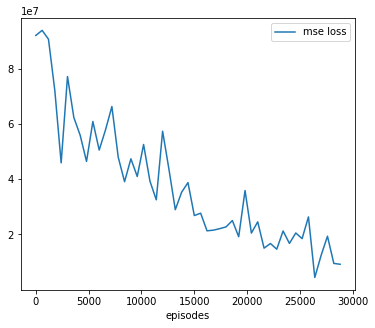

In [ ]:
if rl_algo != "PolicyGradient":
  fig = plt.figure(figsize=figsize)
  loss_agent0_mse = [loss[0] for loss in losses_list]

  x = list(save_every * np.arange(len(loss_agent0_mse)))
  plt.plot(x, loss_agent0_mse, label = f"{loss_str} loss")
  plt.xlabel("episodes")
  # plt.ylim(0, 1e8)
  plt.legend()
  plt.savefig(agent0_dir + f"/{loss_str}_loss.png")
  plt.show()

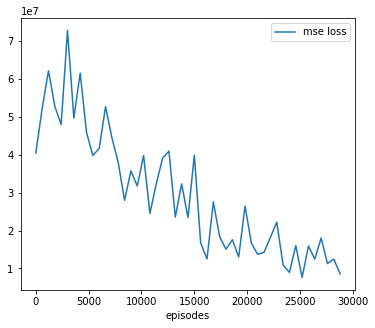

In [ ]:
if rl_algo != "PolicyGradient":
  fig = plt.figure(figsize=figsize)
  loss_agent1_mse = [loss[1] for loss in losses_list]

  x = list(save_every * np.arange(len(loss_agent1_mse)))
  plt.plot(x, loss_agent1_mse, label = f"{loss_str} loss")
  plt.xlabel("episodes")
  # plt.ylim(0, 1e10)
  plt.legend()
  plt.savefig(agent1_dir + f"/{loss_str}_loss.png")
  plt.show()


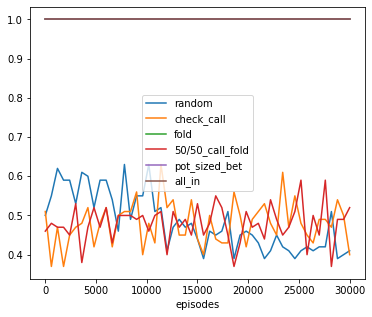

In [ ]:
fig = plt.figure(figsize=figsize)
pwins_agent1 = [pwins[0] for pwins in p_win_list]
x = list(save_every * np.arange(len(pwins_agent1)))

for i, bot_type in enumerate(bot_types):
  plt.plot(x, [wrs[i] for wrs in pwins_agent1], label = f"{bot_type}")


plt.xlabel("episodes")
# plt.ylim(0, 1e10)
plt.legend()
plt.savefig(agent0_dir + f"/winrates.png")
plt.show()


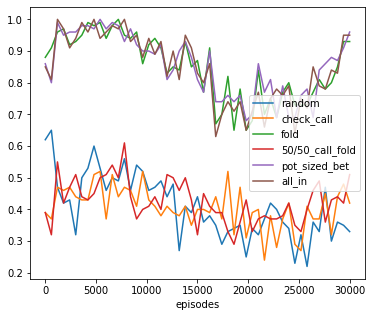

In [ ]:
fig = plt.figure(figsize=figsize)
pwins_agent1 = [pwins[1] for pwins in p_win_list]
x = list(save_every * np.arange(len(pwins_agent1)))

for i, bot_type in enumerate(bot_types):
  plt.plot(x, [wrs[i] for wrs in pwins_agent1], label = f"{bot_type}")


plt.xlabel("episodes")
# plt.ylim(0, 1e10)
plt.legend()
plt.savefig(agent1_dir + f"/winrates.png")
plt.show()


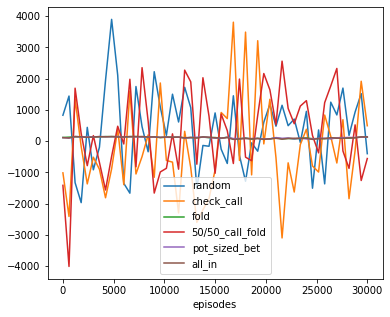

In [ ]:
fig = plt.figure(figsize=figsize)
pwins_agent1 = [pwins[1] for pwins in rewards_list]
x = list(save_every * np.arange(len(pwins_agent1)))

for i, bot_type in enumerate(bot_types):
  plt.plot(x, [wrs[i] for wrs in pwins_agent1], label = f"{bot_type}")


plt.xlabel("episodes")
# plt.ylim(0, 1e10)
plt.legend()
plt.savefig(agent1_dir + f"/avg_reward.png")
plt.show()
  

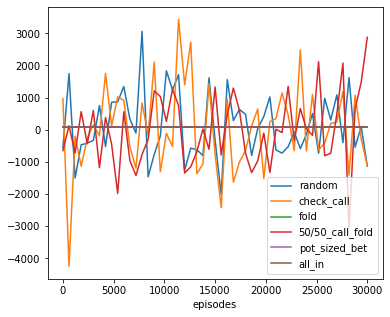

In [ ]:
fig = plt.figure(figsize=figsize)
pwins_agent1 = [pwins[0] for pwins in rewards_list]
x = list(save_every * np.arange(len(pwins_agent1)))

for i, bot_type in enumerate(bot_types):
  plt.plot(x, [wrs[i] for wrs in pwins_agent1], label = f"{bot_type}")


plt.xlabel("episodes")
# plt.ylim(0, 1e10)
plt.legend()
plt.savefig(agent0_dir + f"/avg_reward.png")
plt.show()


In [ ]:
if rl_algo == "PolicyGradient":
  loss_agent0 = [loss[0] for loss in losses_list]
  loss_agent0_critic = [loss[0] for loss in loss_agent0]
  loss_agent0_pi = [loss[1] for loss in loss_agent0]

  x = list(save_every * np.arange(len(loss_agent0)))

In [ ]:
if rl_algo == "PolicyGradient":
  fig = plt.figure(figsize=figsize)
  plt.plot(x, loss_agent0_critic, label = "Critic loss")
  plt.xlabel("episodes")
  plt.legend()
  plt.savefig(agent0_dir + f"/{loss_str}_critic_loss.png")
  plt.show()


In [ ]:
if rl_algo == "PolicyGradient":
  fig = plt.figure(figsize=figsize)
  plt.plot(x, loss_agent0_pi, label = "Pi loss")
  plt.xlabel("episodes")
  plt.legend()
  plt.savefig(agent0_dir + f"/{loss_str}_pi_loss.png")
  plt.show()


In [ ]:
if rl_algo == "PolicyGradient":
  loss_agent1 = [loss[1] for loss in losses_list]
  loss_agent1_critic = [loss[0] for loss in loss_agent1]
  loss_agent1_pi = [loss[1] for loss in loss_agent1]

  x = list(save_every * np.arange(len(loss_agent1)))

In [ ]:
if rl_algo == "PolicyGradient":
  fig = plt.figure(figsize=figsize)
  plt.plot(x, loss_agent1_critic, label = "Critic loss")
  plt.xlabel("episodes")
  plt.legend()
  plt.savefig(agent1_dir + f"/{loss_str}_critic_loss.png")
  plt.show()


In [ ]:
if rl_algo == "PolicyGradient":
  fig = plt.figure(figsize=figsize)
  plt.plot(x, loss_agent1_pi, label = "Pi loss")
  plt.xlabel("episodes")
  plt.legend()
  plt.savefig(agent1_dir + f"/{loss_str}_pi_loss.png")  
  plt.show()

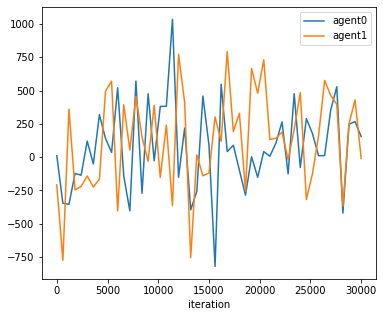

In [ ]:
fig = plt.figure(figsize=figsize)
pwins_agent1 = [pwins[0] for pwins in rewards_list]
x = list(save_every * np.arange(len(pwins_agent1)))
plt.plot(x, [mean(wrs) for wrs in pwins_agent1], label = 'agent0')

pwins_agent1 = [pwins[1] for pwins in rewards_list]
x = list(save_every * np.arange(len(pwins_agent1)))
plt.plot(x, [mean(wrs) for wrs in pwins_agent1], label = 'agent1')

plt.xlabel("iteration")
# plt.ylim(0, 1e10)
plt.legend()
plt.savefig(output_dir + f"/avg_mean_reward.png")
plt.show()

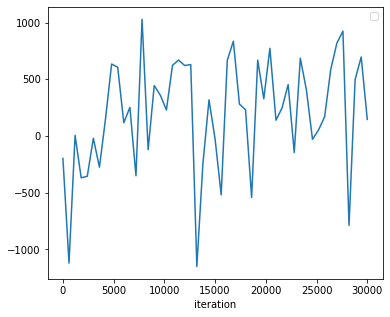

In [ ]:
fig = plt.figure(figsize=figsize)
x = list(save_every * np.arange(len(pwins_agent1)))

pwins_agent1 = [pwins[0] for pwins in rewards_list]
gain0 = np.array([mean(wrs) for wrs in pwins_agent1])

pwins_agent1 = [pwins[1] for pwins in rewards_list]
gain1 = np.array([mean(wrs) for wrs in pwins_agent1])

gain = gain0 + gain1

plt.plot(x, gain)



plt.xlabel("iteration")
# plt.ylim(0, 1e10)
plt.legend()
plt.savefig(output_dir + f"/avg_mean_gain_reward.png")
plt.show()

## Final evaluation of both agents against different baseline bots

In [ ]:
!zip -r '/content/outputs.zip' '/content/outputs'


  adding: content/outputs/ (stored 0%)
  adding: content/outputs/dqn/ (stored 0%)
  adding: content/outputs/dqn/agent_1/ (stored 0%)
  adding: content/outputs/dqn/agent_1/avg_reward.png (deflated 2%)
  adding: content/outputs/dqn/agent_1/winrates.png (deflated 1%)
  adding: content/outputs/dqn/agent_1/mse_loss.png (deflated 4%)
  adding: content/outputs/dqn/avg_mean_reward.png (deflated 2%)
  adding: content/outputs/dqn/avg_mean_gain_reward.png (deflated 4%)
  adding: content/outputs/dqn/agent_0/ (stored 0%)
  adding: content/outputs/dqn/agent_0/avg_reward.png (deflated 2%)
  adding: content/outputs/dqn/agent_0/winrates.png (deflated 4%)
  adding: content/outputs/dqn/agent_0/mse_loss.png (deflated 5%)
